In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [4]:
##LOAD TRAINING DATAFRAME

# categorical variable train dataframe

file_path_trainC = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx"
train_cat = pd.read_excel(file_path_trainC)

# Functional Connectome Matrices

file_path_trainFCM = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
train_FCM = pd.read_csv(file_path_trainFCM)

# Quantitative varaible train dataframe

file_path_trainQ = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx"
train_Quant = pd.read_excel(file_path_trainQ)

# ADHD and Sex solutions dataframe for model training

file_path_trainS = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx"
train_Solutions = pd.read_excel(file_path_trainS)

In [5]:
##LOAD TEST DATAFRAME

# categorical variable test dataframe

file_path_testC = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx"
test_cat = pd.read_excel(file_path_testC)

# Functional Connectome Matrices

file_path_testFCM = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_FCM = pd.read_csv(file_path_testFCM)

# Quantitative varaible test dataframe

file_path_testQ = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx"
test_Quant = pd.read_excel(file_path_testQ)

In [50]:
train_FCM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Columns: 19903 entries, participant_id to max_activity_value
dtypes: float64(19901), object(2)
memory usage: 184.2+ MB


In [7]:
test_FCM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Columns: 19901 entries, participant_id to 198throw_199thcolumn
dtypes: float64(19900), object(1)
memory usage: 46.2+ MB


In [46]:
test_FCM.dtypes

participant_id           object
0throw_1thcolumn        float64
0throw_2thcolumn        float64
0throw_3thcolumn        float64
0throw_4thcolumn        float64
                         ...   
196throw_198thcolumn    float64
196throw_199thcolumn    float64
197throw_198thcolumn    float64
197throw_199thcolumn    float64
198throw_199thcolumn    float64
Length: 19901, dtype: object

In [48]:
train_FCM.dtypes

participant_id           object
0throw_1thcolumn        float64
0throw_2thcolumn        float64
0throw_3thcolumn        float64
0throw_4thcolumn        float64
                         ...   
197throw_198thcolumn    float64
197throw_199thcolumn    float64
198throw_199thcolumn    float64
max_activity_region      object
max_activity_value      float64
Length: 19903, dtype: object

In [92]:
#Identify which region has the most activity (train)
train_FCM['max_activity_region'] = train_FCM.iloc[:, 1:1990].idxmax(axis=1)
train_FCM['max_activity_value'] = train_FCM.iloc[:, 1:1990].max(axis=1)
train_FCM_max = train_FCM[['participant_id','max_activity_region','max_activity_value']]
train_FCM_max.head()

,participant_id,max_activity_region,max_activity_value
0,70z8Q2xdTXM3,1throw_103thcolumn,0.314661
1,WHWymJu6zNZi,7throw_9thcolumn,0.215325
2,4PAQp1M6EyAo,1throw_103thcolumn,0.288996
3,obEacy4Of68I,2throw_102thcolumn,0.227515
4,s7WzzDcmDOhF,1throw_3thcolumn,0.236001


In [90]:
train_FCM_max.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   participant_id       1213 non-null   object 
 1   max_activity_region  1213 non-null   object 
 2   max_activity_value   1213 non-null   float64
dtypes: float64(1), object(2)
memory usage: 28.6+ KB


In [30]:
#Distibution of region with highest activity(train)
max_activity_region_counts = train_FCM_max['max_activity_region'].value_counts()
print(max_activity_region_counts)

max_activity_value_sorted = train_FCM_max.sort_values(by='max_activity_value', ascending=False)

print(max_activity_value_sorted)


max_activity_region
1throw_103thcolumn    436
2throw_102thcolumn    131
3throw_103thcolumn    115
1throw_3thcolumn      109
8throw_107thcolumn     74
                     ... 
5throw_196thcolumn      1
1throw_100thcolumn      1
8throw_10thcolumn       1
10throw_11thcolumn      1
8throw_22thcolumn       1
Name: count, Length: 84, dtype: int64
    participant_id max_activity_region  max_activity_value
486   LkE795nTZE14  3throw_103thcolumn            0.550239
788   Jh14rFpVd8Km  1throw_103thcolumn            0.538463
389   4VIE7TEmlPr9  1throw_103thcolumn            0.514260
645   CKkgPNyqu2OK  1throw_103thcolumn            0.505297
787   D3JcJiXCwQK2  1throw_103thcolumn            0.504691
..             ...                 ...                 ...
963   jEv0KvTTZ0Mj   6throw_10thcolumn            0.165244
932   BcN00QkRO7Vd  8throw_107thcolumn            0.163948
464   syeyZjEx8FUx  5throw_196thcolumn            0.161367
563   zHyPVux7ymz0    1throw_3thcolumn            0.156360
397   4

In [22]:
print(train_Solutions)

     participant_id  ADHD_Outcome  Sex_F
0      UmrK0vMLopoR             1      1
1      CPaeQkhcjg7d             1      0
2      Nb4EetVPm3gs             1      0
3      p4vPhVu91o4b             1      1
4      M09PXs7arQ5E             1      1
...             ...           ...    ...
1208   Atx7oub96GXS             0      0
1209   groSbUfkQngM             0      1
1210   zmxGvIrOD0bt             0      1
1211   rOmWFuJCud5G             0      0
1212   k8HhHnnu2wmt             0      0

[1213 rows x 3 columns]


In [28]:
#train solutions distributions
female_counts = train_Solutions['Sex_F'].value_counts()
print(female_counts)
adhd_counts = train_Solutions['ADHD_Outcome'].value_counts()
print(adhd_counts)

Sex_F
0    797
1    416
Name: count, dtype: int64
ADHD_Outcome
1    831
0    382
Name: count, dtype: int64


In [100]:
#one hot encoding on FCM 
train_encoded_FCM = pd.get_dummies(train_FCM_max['max_activity_region'], drop_first=True)
train_encoded_FCM = train_encoded_FCM.map(lambda x: 1 if x is True else (0 if x is False else x))
print(train_encoded_FCM)

# Combine encoded columns with the rest of the DataFrame
train_FCM_final = pd.concat([train_FCM_max, train_encoded_FCM], axis=1)

# ensure it looks correct
train_FCM_final.head()

      0throw_102thcolumn  0throw_103thcolumn  0throw_1thcolumn  \
0                      0                   0                 0   
1                      0                   0                 0   
2                      0                   0                 0   
3                      0                   0                 0   
4                      0                   0                 0   
...                  ...                 ...               ...   
1208                   0                   0                 0   
1209                   0                   0                 0   
1210                   0                   0                 0   
1211                   0                   0                 0   
1212                   0                   0                 0   

      0throw_29thcolumn  0throw_2thcolumn  0throw_3thcolumn  0throw_6thcolumn  \
0                     0                 0                 0                 0   
1                     0                 0    

,participant_id,max_activity_region,max_activity_value,0throw_102thcolumn,0throw_103thcolumn,0throw_1thcolumn,0throw_29thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_6thcolumn,...,8throw_60thcolumn,8throw_65thcolumn,8throw_83thcolumn,8throw_90thcolumn,8throw_92thcolumn,8throw_97thcolumn,9throw_108thcolumn,9throw_109thcolumn,9throw_10thcolumn,9throw_11thcolumn
0,70z8Q2xdTXM3,1throw_103thcolumn,0.314661,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,WHWymJu6zNZi,7throw_9thcolumn,0.215325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4PAQp1M6EyAo,1throw_103thcolumn,0.288996,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,obEacy4Of68I,2throw_102thcolumn,0.227515,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,s7WzzDcmDOhF,1throw_3thcolumn,0.236001,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
#combine solutions with FCM 
train_FCM_final = train_FCM_final[['participant_id','1throw_103thcolumn']]
print(train_FCM_final)

train_sol_FCM_final = pd.merge(train_FCM_final, train_Solutions, on = 'participant_id')
print(train_sol_FCM_final)

     participant_id  1throw_103thcolumn
0      70z8Q2xdTXM3                   1
1      WHWymJu6zNZi                   0
2      4PAQp1M6EyAo                   1
3      obEacy4Of68I                   0
4      s7WzzDcmDOhF                   0
...             ...                 ...
1208   kTurROKp5YHQ                   1
1209   FCRyMz9O6yCq                   0
1210   vm2P1hmAY1hl                   0
1211   OFxvN8lnw21w                   0
1212   9gpepMI9sj5q                   0

[1213 rows x 2 columns]
     participant_id  1throw_103thcolumn  ADHD_Outcome  Sex_F
0      70z8Q2xdTXM3                   1             1      0
1      WHWymJu6zNZi                   0             1      1
2      4PAQp1M6EyAo                   1             1      1
3      obEacy4Of68I                   0             1      1
4      s7WzzDcmDOhF                   0             1      1
...             ...                 ...           ...    ...
1208   kTurROKp5YHQ                   1             0      1
1209   

ADHD_Outcome          0    1
1throw_103thcolumn          
0                   248  529
1                   134  302


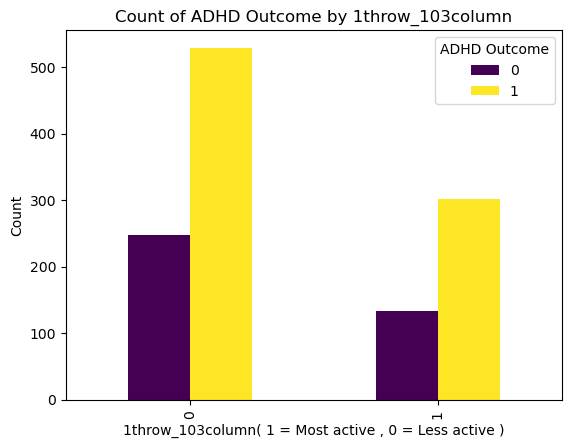

In [126]:
#check correlation of most active region with ADHD outcome 

# create contingency table 
ct_ADHD_active_region = pd.crosstab(train_sol_FCM_final['1throw_103thcolumn'], train_sol_FCM_final['ADHD_Outcome'])
print(ct_ADHD_active_region)

#create stacked bar chart
ct_ADHD_active_region .plot(kind='bar', colormap='viridis')
plt.title("Count of ADHD Outcome by 1throw_103column")
plt.xlabel("1throw_103column( 1 = Most active , 0 = Less active )")
plt.ylabel("Count")
plt.legend(title="ADHD Outcome")
plt.show()

Sex_F                 0    1
1throw_103thcolumn          
0                   500  277
1                   297  139


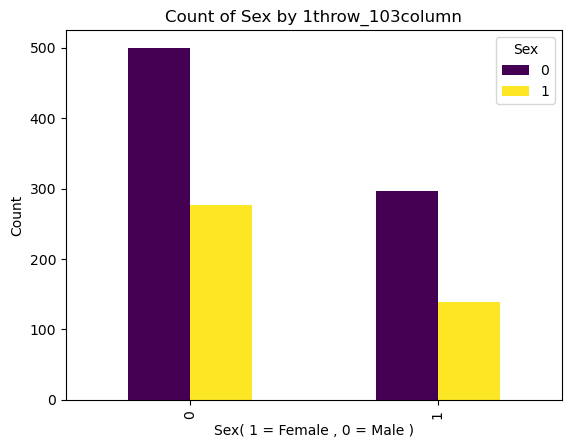

In [128]:
#check correlation of most active region with Sex 

# create contingency table 
ct_sex_active_region = pd.crosstab(train_sol_FCM_final['1throw_103thcolumn'], train_sol_FCM_final['Sex_F'])
print(ct_sex_active_region)

#create stacked bar chart
ct_sex_active_region .plot(kind='bar', colormap='viridis')
plt.title("Count of Sex by 1throw_103column")
plt.xlabel("Sex( 1 = Female , 0 = Male )")
plt.ylabel("Count")
plt.legend(title="Sex")
plt.show()

ADHD_Outcome          0   1
max_activity_region        
0throw_100thcolumn   10  10
0throw_102thcolumn    0   1
0throw_103thcolumn    0   2
0throw_1thcolumn      3   4
0throw_29thcolumn     0   2
...                  ..  ..
8throw_97thcolumn     0   3
9throw_108thcolumn   19  28
9throw_109thcolumn    6  13
9throw_10thcolumn     1   4
9throw_11thcolumn     1   0

[84 rows x 2 columns]


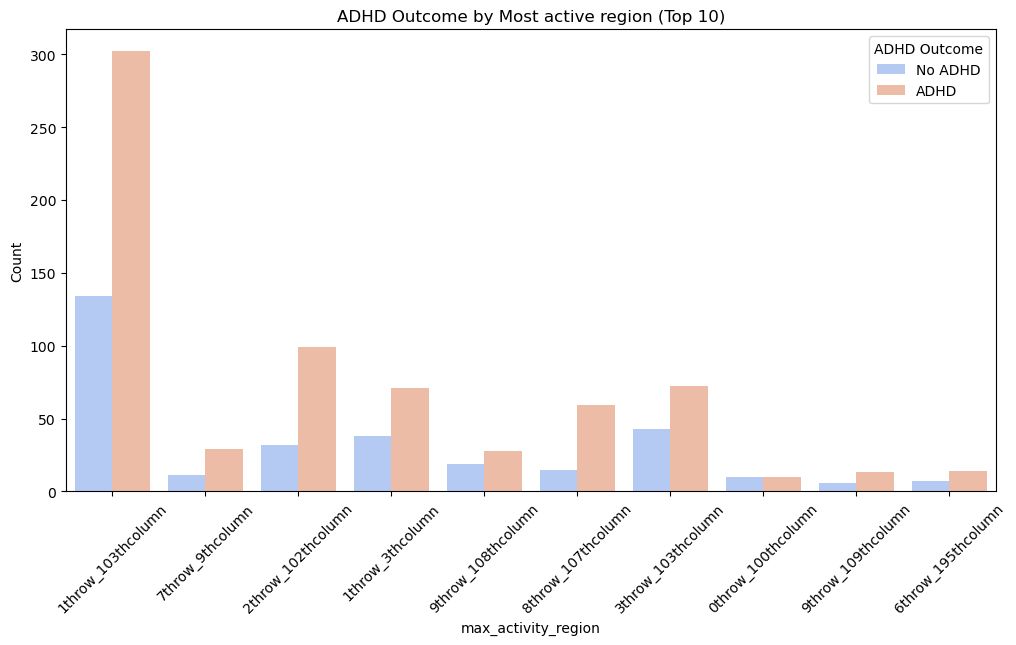

In [145]:
#identify most active region in ADHD patient
#merge FCM max and solutions 
train_sol_FCM_max = pd.merge(train_FCM_max, train_Solutions, on = 'participant_id')

# create contingency table FCM max and adhd outcome
ct_ADHD_max_activity_regions = pd.crosstab(train_sol_FCM_max['max_activity_region'], train_sol_FCM_max['ADHD_Outcome'])
print(ct_ADHD_max_activity_regions)

# bar chart (top 10)

# Count occurrences
category_counts = train_sol_FCM_max['max_activity_region'].value_counts()

# Select top 10 categories
top_categories = category_counts.index[:10]
dfadhd_filtered = train_sol_FCM_max[train_sol_FCM_max['max_activity_region'].isin(top_categories)]

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(x='max_activity_region', hue='ADHD_Outcome', data=dfadhd_filtered, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("ADHD Outcome by Most active region (Top 10)")
plt.xlabel("max_activity_region")
plt.ylabel("Count")
plt.legend(title="ADHD Outcome", labels=["No ADHD", "ADHD"])
plt.show()

Sex_F                 0   1
max_activity_region        
0throw_100thcolumn   13   7
0throw_102thcolumn    0   1
0throw_103thcolumn    2   0
0throw_1thcolumn      6   1
0throw_29thcolumn     2   0
...                  ..  ..
8throw_97thcolumn     2   1
9throw_108thcolumn   36  11
9throw_109thcolumn   15   4
9throw_10thcolumn     2   3
9throw_11thcolumn     0   1

[84 rows x 2 columns]


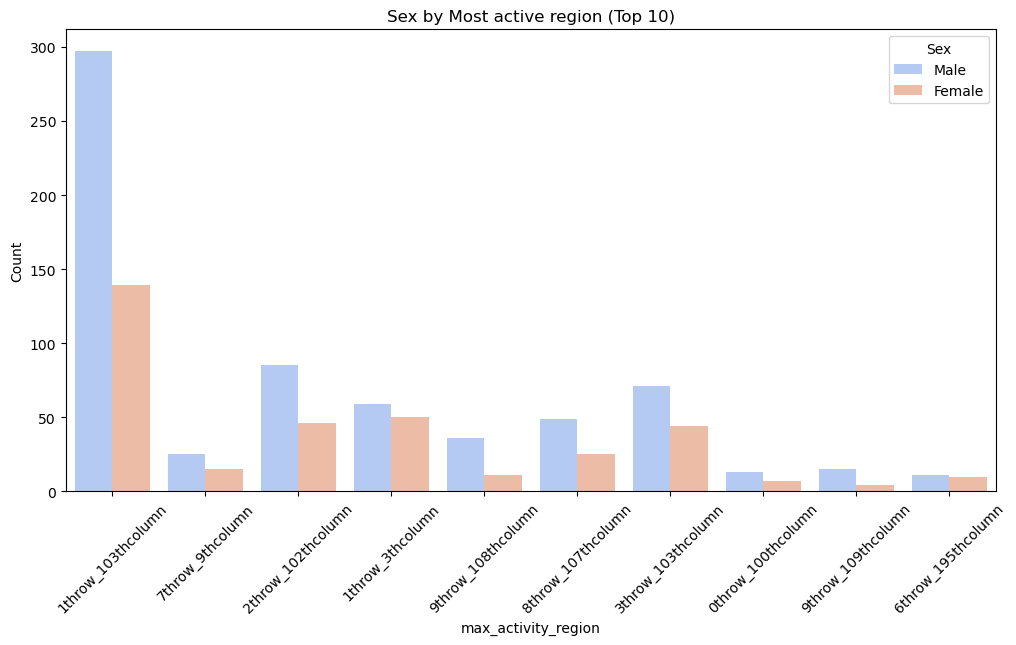

In [149]:
#identify most active region in different sex 
#merge FCM max and solutions 
train_sol_FCM_max = pd.merge(train_FCM_max, train_Solutions, on = 'participant_id')

# create contingency table FCM max and adhd outcome
ct_sex_max_activity_regions = pd.crosstab(train_sol_FCM_max['max_activity_region'], train_sol_FCM_max['Sex_F'])
print(ct_sex_max_activity_regions)

# bar chart (top 10)

# Count occurrences
category_counts = train_sol_FCM_max['max_activity_region'].value_counts()

# Select top 10 categories
top_categories = category_counts.index[:10]
dfsex_filtered = train_sol_FCM_max[train_sol_FCM_max['max_activity_region'].isin(top_categories)]

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(x='max_activity_region', hue='Sex_F', data=dfsex_filtered, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Sex by Most active region (Top 10)")
plt.xlabel("max_activity_region")
plt.ylabel("Count")
plt.legend(title="Sex", labels=["Male", "Female"])
plt.show()

Sex_F           0    1
ADHD_Outcome          
0             216  166
1             581  250


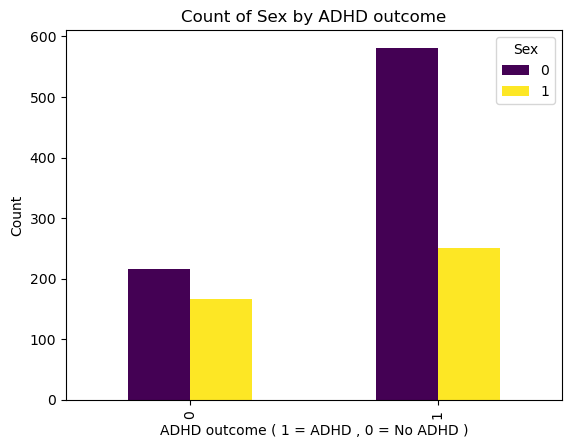

In [175]:
#check correlation of ADHD with Sex 

# create contingency table 
ct_sex_adhd = pd.crosstab(train_Solutions['ADHD_Outcome'], train_Solutions['Sex_F'])
print(ct_sex_adhd )

#create stacked bar chart
ct_sex_adhd.plot(kind='bar', colormap='viridis')
plt.title("Count of Sex by ADHD outcome")
plt.xlabel("ADHD outcome ( 1 = ADHD , 0 = No ADHD )")
plt.ylabel("Count")
plt.legend(title="Sex")
plt.show()

In [155]:
#count males and females entry 
sex_counts = train_Solutions['Sex_F'].value_counts()
print(sex_counts)

Sex_F
0    797
1    416
Name: count, dtype: int64


In [161]:
#count males and females entry 
sex_counts = train_Solutions['ADHD_Outcome'].value_counts()
print(sex_counts)

ADHD_Outcome
1    831
0    382
Name: count, dtype: int64


C:\Users\sitif\AppData\Local\Temp\ipykernel_20448\1076791019.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\sitif\AppData\Local\Temp\ipykernel_20448\1076791019.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


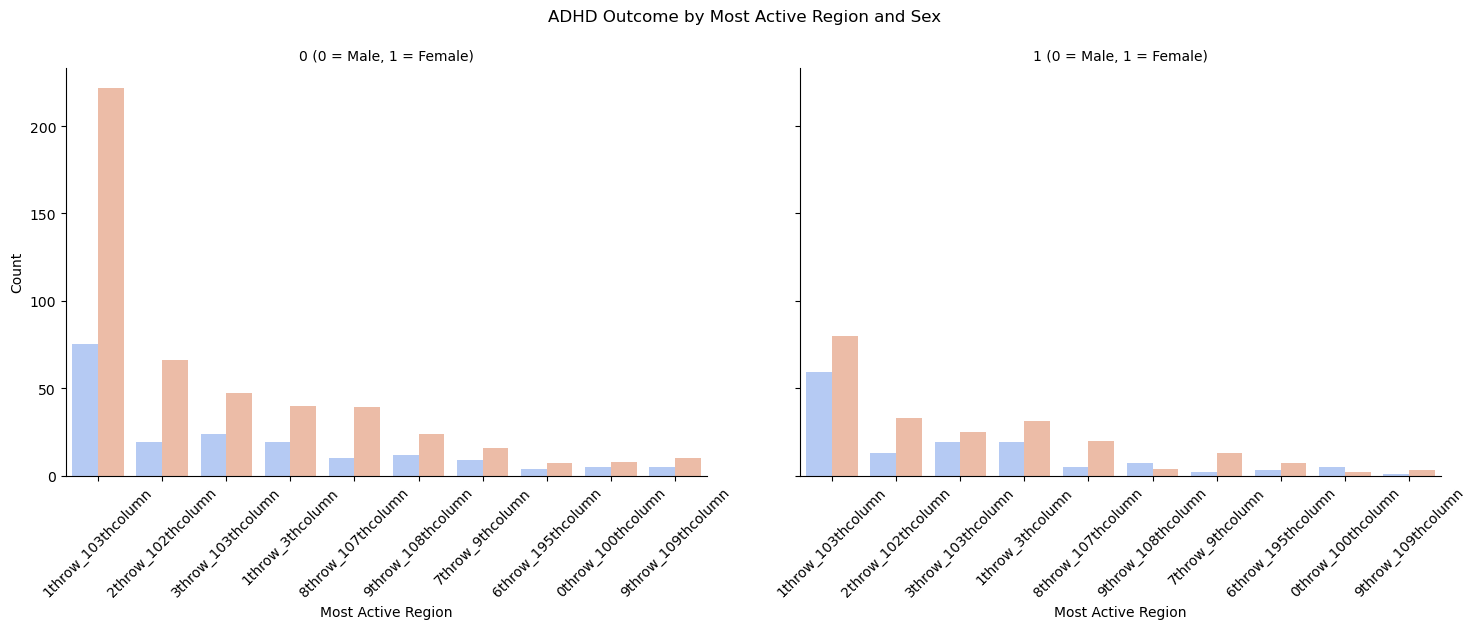

In [173]:
#add sex variable

# Select top 10 most frequent activity regions
top_categories = train_sol_FCM_max['max_activity_region'].value_counts().index[:10]
df_filtered = train_sol_FCM_max[train_sol_FCM_max['max_activity_region'].isin(top_categories)]

# Create facet grid (Separate plots for each sex)
g = sns.FacetGrid(df_filtered, col="Sex_F", height=5, aspect=1.5)
g.map_dataframe(sns.countplot, x="max_activity_region", hue="ADHD_Outcome", palette="coolwarm", order=top_categories)

# Formatting
g.set_axis_labels("Most Active Region", "Count")
g.set_titles(col_template="{col_name} (0 = Male, 1 = Female)")
g.fig.suptitle("ADHD Outcome by Most Active Region and Sex", y=1.05)
for ax in g.axes.flat:  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()
